In [2]:
# llm initialization (not secured with env file baad mai karlena)
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_aws import ChatBedrock
from typing import Annotated
from langchain.docstore.document import Document
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_groq import ChatGroq

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    documents: list[Document] 
    pdf_path:str 
    question: str
    question_type:str
    pdf_context: str
    calender_context: str
    parent__run_id__: str

llm = ChatGroq(model="llama3-70b-8192",api_key="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")

In [3]:
# rag tool 
import spacy,pickle,os,boto3 
from langchain_core.tools import tool
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from pdfminer.high_level import extract_text
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

@tool(description="This tool extracts text from a PDF, cleans it, lemmatizes it, and stores it in a vector store for retrieval.")
def rag_tool(state: GraphState) -> None:
    
    path = state["pdf_path"]
    
    def text_extracter(path):
        text = extract_text(path)
        return text

    def text_chunk(text):
        splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200,separators = ["\n\n", "\n", ".", " ", ""])
        chunks = splitter.split_text(text)
        return chunks
    
    nlp = spacy.load('en_core_web_sm')

    def text_cleaning(chunks):
        cleaned_chunks = []
        for chunk in chunks:
            doc = nlp(chunk)
            cleaned = " ".join([token.text for token in doc if not token.is_stop and not token.is_punct])
            cleaned_chunks.append(cleaned)
        return cleaned_chunks
    
    def lemmatize_text(cleaned_chunks):
        lemma_chunks = []
        for chunk in cleaned_chunks:
            doc = nlp(chunk)
            lemma = " ".join([token.lemma_ for token in doc])
            lemma_chunks.append(lemma)
        return lemma_chunks
    
    def load_store():
        storage_dir = "/Users/pmanthan/Desktop/tomo.ai/faiss_storage"
        with open("/Users/pmanthan/Desktop/tomo.ai/faiss_storage/faiss_storage.pkl", "rb") as f:
            embeddings = pickle.load(f)
        
        vector_store = FAISS.load_local(storage_dir, embeddings, allow_dangerous_deserialization=True)
        return vector_store

    def embed_store(lemma_chunks):
        docs = [Document(page_content=chunk) for chunk in lemma_chunks]
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        db = FAISS.from_documents(docs, embeddings)  # FAISS - Facebook AI Similarity Search (full form for revision)
        
        storage_dir = "/Users/pmanthan/Desktop/tomo.ai/faiss_storage"
        os.makedirs(storage_dir, exist_ok=True)
        db.save_local(storage_dir)
        
        with open("/Users/pmanthan/Desktop/tomo.ai/faiss_storage/faiss_storage.pkl", "wb") as f:
            pickle.dump(embeddings, f)
        
        return db
    
    def rag_pipeline(path): 
        extracted_text = text_extracter(path)
        chunked_text = text_chunk(extracted_text)
        cleaned_text = text_cleaning(chunked_text)
        lemma_text = lemmatize_text(cleaned_text)
        embed_store(lemma_text)
        embed_text = load_store()
        return embed_text
    
    def retrieve_data(path: str,state: GraphState) -> None:
        vector_store = rag_pipeline(path)
        state["documents"] = vector_store.as_retriever(search_kwargs={"k": 5})
        return state 
    
    vector_store = retrieve_data(path,state)
    return vector_store


In [4]:
# nodes building 
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import create_react_agent, AgentExecutor

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

router_prompt = """You are an AI question router. Your job is to classify incoming user questions to route them to the correct specialized agent.

There are three types of questions:
- PDF: Questions that involve reading, summarizing, or querying the content of a PDF document.
- CALENDAR: Questions related to scheduling, managing events, or checking availability using Google Calendar.
- None: Questions that do not fit into either category.
When you receive a question, determine its type based on the content and context.

Only respond with one word: PDF or CALENDAR.
"""

pdf_prompt = """You are an expert in reading and answering questions based on the content of a PDF document.

Your goal is to:
- Answer user questions using the content of the PDF
- If no specific question is asked, summarize the key points of the document
- Keep responses concise and relevant to the document

Respond clearly and based only on the content provided.
"""

calendar_prompt = """You are a scheduling assistant that interfaces with Google Calendar.

Your tasks include:
- Scheduling meetings or events
- Checking availability
- Canceling or rescheduling events

You will receive a natural language question and should interpret it to perform the correct calendar action.
If you need more details (like time or date), ask the user.
"""



def router_node(state:GraphState):
    messages = [SystemMessage(content=router_prompt), HumanMessage(content=state["question"])]
    router_model = llm
    response = router_model.invoke(messages)
    return {"question_type" : response.content}

def rag_node(state:GraphState):
    vector_store = rag_tool(state["pdf_path"], state)
    retriever_tool = create_retriever_tool(vector_store, name="rag_tool", description="A tool to retrieve relevant information from a PDF document.",checkpointer=memory) 
    rag_agent = create_react_agent(llm=llm,tools=[retriever_tool] )
    messages = [SystemMessage(content=pdf_prompt),HumanMessage(content=state["question"])]
    response = rag_agent.invoke(messages)
    return {"pdf_context": response.content} if response else None

def general_assiant_node(state:GraphState):
    messages = [SystemMessage(content="You are a helpful assistant."), HumanMessage(content=state["question"])]
    general_agent = create_react_agent(llm=llm)
    response = general_agent.invoke(messages)
    return {"calender_context": response.content} if response else None


/var/folders/gn/l9789lc92mxgrlbrvzzxm2d80000gn/T/ipykernel_58071/1353283477.py:6: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


In [5]:
# conditional edges 
def route_question(state: GraphState):
    question_type = state["question_type"]
    return question_type

In [6]:
# create our graph 
from langgraph.graph.state import StateGraph
from langgraph.graph.state import END  
from langgraph.graph.state import START

tomo_ai = StateGraph(GraphState)
tomo_ai.add_node("router node", router_node)
tomo_ai.add_node("rag node", rag_node,)
tomo_ai.add_node("general_assiant_node", general_assiant_node)
tomo_ai.add_edge(START,"router node")
tomo_ai.add_conditional_edges("router node", route_question, {"PDF": "rag node", "CALENDAR": "general_assiant_node", "None": "general_assiant_node"})
tomo_ai.add_edge("rag node", END)
tomo_ai.add_edge("router node", END)
tomo_ai.add_edge("general_assiant_node", END)

In [7]:
graph = tomo_ai.compile()

thread = {"configurable": {"thread_id": "2"}}
results = []
for s in graph.stream({
  'question': "what is the main topic of the document?",
  'pdf_path':"/Users/pmanthan/Desktop/AIC /AICommunity_Assignment_25.pdf"
}, thread):
  print(s)
  results.append(s)
print(results[-1]['database_expert']['answer'])

{'router node': {'question_type': 'PDF'}}


/var/folders/gn/l9789lc92mxgrlbrvzzxm2d80000gn/T/ipykernel_58071/1353283477.py:49: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  vector_store = rag_tool(state["pdf_path"], state)


AttributeError: 'dict' object has no attribute 'parent_run_id'

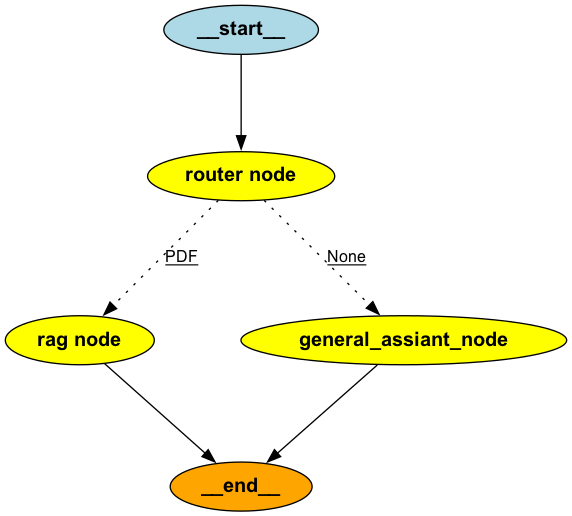

In [19]:
# display the graph
from IPython.display import Image
Image(graph.get_graph().draw_png())